941  x  1333


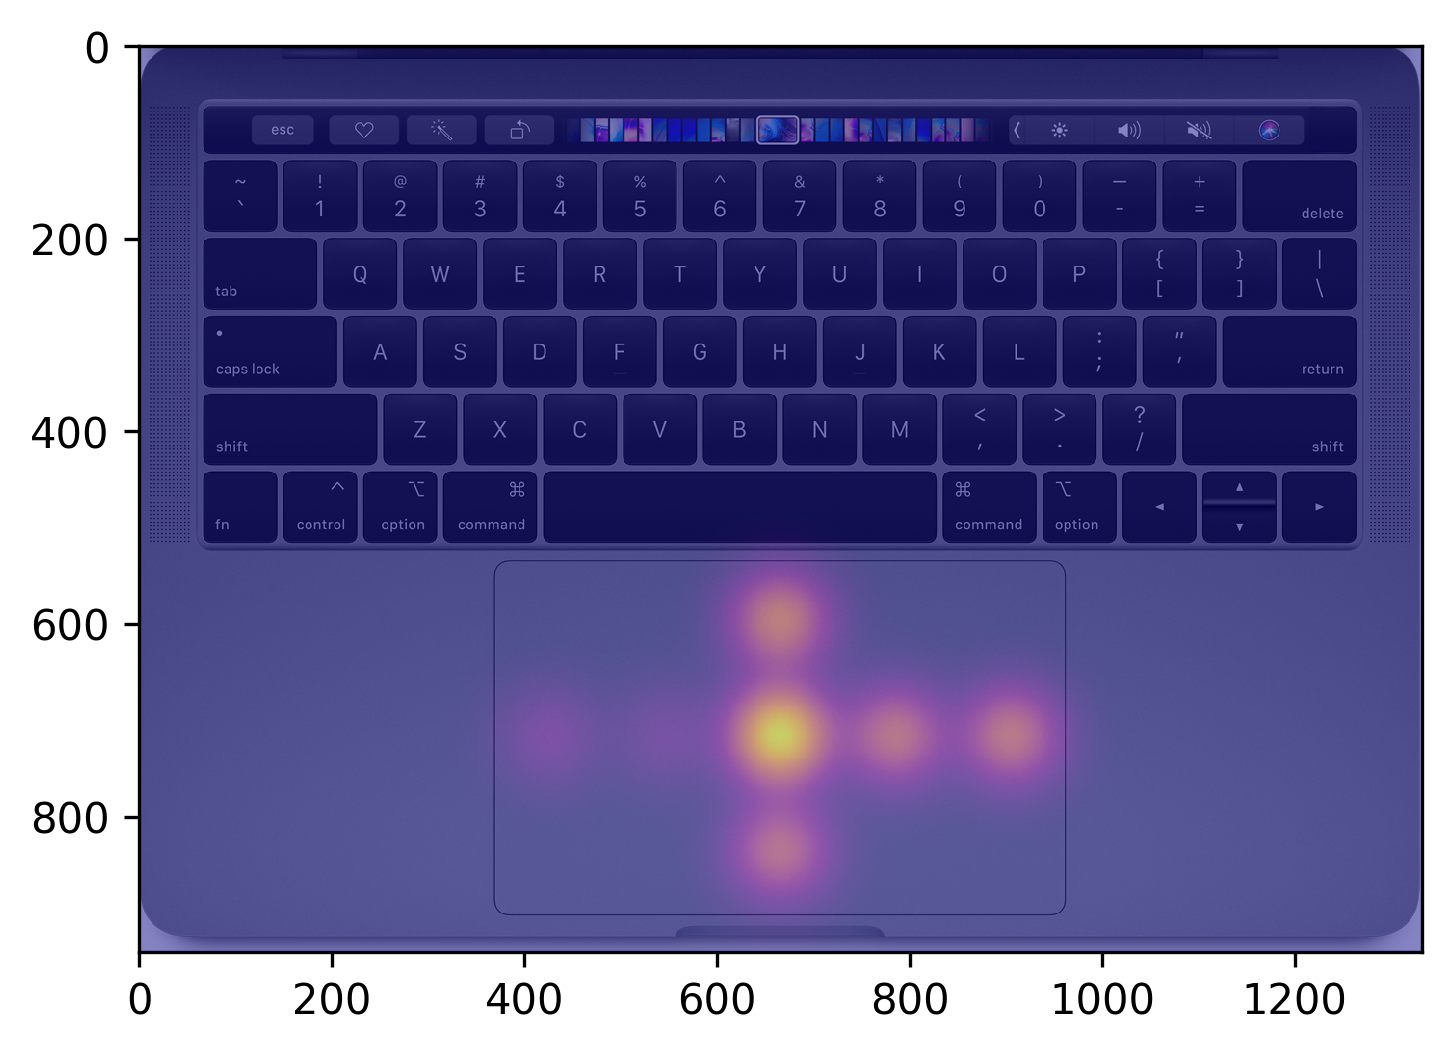

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-5d7a948d9733>", line 3, in <module>
    hm.genHeatmaps(UDP_PORT=9000, display=True)
  File "/Users/carbone/workspace/arc_frontends/arc_beam/demo/heatmaps.py", line 61, in genHeatmaps
    heat_map = ndimage.filters.gaussian_filter(nextHeatmap(sock), sigma=35)
  File "/Users/carbone/workspace/arc_frontends/arc_beam/demo/heatmaps.py", line 42, in nextHeatmap
    data, addr = sock.recvfrom(1024) # buffer size is 1024 bytes
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During

KeyboardInterrupt: 

In [1]:
%matplotlib inline
import heatmaps as hm
hm.genHeatmaps(UDP_PORT=9000, display=True)

In [ ]:
from typing import Tuple

import arc_beam as beam
import arc_beam.transforms.window as window
import arc_beam.transforms.combiners as combiners
import baloo as pandas



p = beam.Pipeline()
width, height = 500, 300  # 500x300 points on touchpad
num_x_grids, num_y_grids = 5, 3  # 5x3 grids
grid_width, grid_height = int(width / num_x_grids), int(height / num_y_grids)  # height/width of grids
epsilon = 0.1
window_length = 6

trackpad = '127.0.0.1:8000'
display = '127.0.0.1:9000'

(p
 | beam.io.ReadFromSocket(trackpad, beam.coders.CSVCoder()).with_output_types(
            #      ts,     x,     y,     z
            Tuple[int, float, float, float])

 | 'preprocess' >> beam.Filter(lambda e: (e[3] >= 0.0) & (e[3] < 1.0))
 | 'extract timestamp' >> beam.Map(lambda e: window.TimestampedValue(e[1:4], e[0]))
 | 'extract key' >> beam.Map(lambda e: (((e[0] / grid_width).asInt(), (e[1] / grid_height).asInt()), e[2]))
 | 'add to pressure' >> beam.Map(lambda e: (e[0], e[1] + epsilon))
 | 'create tumbling window' >> beam.WindowInto(window.FixedWindows(window_length))
 | 'sum up pressures' >> beam.CombinePerKey(lambda e: pandas.Series(e).sum())
 | 'collect window as list' >> combiners.ToList()

 | beam.io.WriteToSocket(display, beam.coders.CSVCoder()))

p.run()